# Encoders: Categorical Example

Encoders can also use embeddings as this example will show.

----
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

## Imports

In [1]:
import torch
import numpy as np
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.
The `from_csv` method will read the file and return a Pandas DataFrame object

In [3]:
# Change this to read from another location
file = '../../../data/bs140513_032310.csv'

In [4]:
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

base_features = ft.TensorDefinition(
    'base', 
    [
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])


age_i = ft.FeatureIndex('age_index', ft.FEATURE_TYPE_INT_8, age)
gender_i = ft.FeatureIndex('gender_index', ft.FEATURE_TYPE_INT_8, gender)
merchant_i = ft.FeatureIndex('merchant_index', ft.FEATURE_TYPE_INT_16, merchant)
category_i = ft.FeatureIndex('category_index', ft.FEATURE_TYPE_INT_16, category)
amount_binned = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 30)
fraud_label = ft.FeatureLabelBinary('fraud_label', fraud)

learning_features = ft.TensorDefinition(
    'learning', 
    [
        age_i,
        gender_i,
        merchant_i,
        category_i,
        amount_binned,
        fraud_label
    ])

with en.EnginePandasNumpy() as e:
    df = e.from_csv(base_features, file, inference=False)
    df = e.from_df(learning_features, df, inference=False)

df

2020-11-12 15:17:19.212 d373c7.engines.common          INFO     Start Engine...
2020-11-12 15:17:19.213 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.2
2020-11-12 15:17:19.213 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-11-12 15:17:19.213 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../data/bs140513_032310.csv
2020-11-12 15:17:19.413 d373c7.engines.panda_numpy     INFO     Building Panda for : <base> from DataFrame. Inference mode <False>
2020-11-12 15:17:19.418 d373c7.engines.panda_numpy     INFO     Done creating base. Shape=(594643, 6)
2020-11-12 15:17:19.419 d373c7.engines.panda_numpy     INFO     Building Panda for : <learning> from DataFrame. Inference mode <False>
2020-11-12 15:17:19.460 d373c7.engines.panda_numpy     INFO     Done creating learning. Shape=(594643, 6)


,age_index,gender_index,merchant_index,category_index,amount_bin,fraud_label
0,1,1,1,1,1,0
1,2,1,1,1,1,0
2,1,2,2,1,1,0
3,3,1,1,1,1,0
4,4,1,1,1,1,0
...,...,...,...,...,...,...
594638,3,2,2,1,1,0
594639,1,2,2,1,1,0
594640,2,2,15,11,1,0
594641,4,1,2,1,1,0


## Convert to Numpy

In [5]:
with en.EnginePandasNumpy() as e:
    data_list = e.to_numpy_list(learning_features, df)
print(data_list.shapes)
print(data_list.dtype_names)

2020-11-12 15:17:21.707 d373c7.engines.common          INFO     Start Engine...
2020-11-12 15:17:21.707 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.2
2020-11-12 15:17:21.708 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-11-12 15:17:21.708 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int16
2020-11-12 15:17:21.708 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Categorical
2020-11-12 15:17:21.712 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int8
2020-11-12 15:17:21.712 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Label


[(594643, 5), (594643,)]
['int16', 'int8']


## Wrangle the data
Time split the data. For time series data it is very important to keep the order of the data. This split will start from the end and work it's way to the front of the data. This way the training, validation and test data are nicely colocated in time

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

__Important__. For auto-encoders we perform a 4th step, all fraud records will be removed from the training and validation data. The auto-encoder will only see *non-fraud* records during training.
> 4. Remove fraud from training and validation

In [6]:
test_records = 100000
val_records  = 30000 

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 

# Filter. Only keep non-fraud records with label 0. 
train_data = train_data.filter_label(learning_features, 0)
val_data = val_data.filter_label(learning_features, 0)

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del data_list
gc.collect()
print('Done')

Training Data shapes [(458847, 5), (458847,)]
Validation Data shapes [(29670, 5), (29670,)]
Test Data shapes [(100000, 5), (100000,)]
Done


## Set up Devices

In [8]:
device, cpu = pt.init_devices()

2020-11-12 15:17:29.223 d373c7.pytorch.common          INFO     Torch Version : 1.6.0
2020-11-12 15:17:29.313 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2020-11-12 15:17:29.314 d373c7.pytorch.common          INFO     Cuda Version  : 10.2


## Define model

> Define a __CategoricalToBinaryAutoEncoder__. As input it takes the size of the latent dimension. In this case *3*. And it takes a list of integers indicating the number and the size of the hidden dimensions. *We are defining it to have 1 hidden layer of size 16*.

> As first layer this encoder now uses embeddings. Each categorical feature has its own embedding like in the classification examples. 

In [9]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSet(learning_features, train_data)
val_ds = pt.NumpyListDataSet(learning_features, val_data)

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, shuffle=True)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

# Create a model
m = pm.CategoricalToBinaryAutoEncoder(learning_features, latent_dim=3, layers=[16])
print(m)

CategoricalToBinaryAutoEncoder(
  Number of parameters : 4823
  (encoder): LatentLinearEncoder(
    Number of parameters : 2855
    (head): TensorDefinitionHead(
      lcs=['Categorical']
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(9, 4)
          (1): Embedding(5, 4)
          (2): Embedding(51, 25)
          (3): Embedding(16, 7)
          (4): Embedding(31, 15)
        )
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
    (linear): LinDropAct(
      (layers): Sequential(
        (0): Linear(in_features=55, out_features=16, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): ReLU(inplace=True)
      )
    )
    (latent): Linear(in_features=16, out_features=3, bias=True)
  )
  (decoder): LatentLinearDecoder(
    (linear): LinDropAct(
      (layers): Sequential(
        (0): Linear(in_features=3, out_features=16, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): ReLU(inplace=True)
      )
    )


Graphically the model looks like below. 

>The input is now categorical (5 features) which goes through an embedding layer. The embedding layer outputs the coordinates of the respective feature values. Those coordinates are concatenated. 

> The concatenated *'coordinate'* layer is consensed to 3 latent features.

> And the latent features are decompressed into 112 features. That is more than the 107 one-hot-encoded binary features we had earlier. That is because the embedding have a size which is one more than the values (for the unknown null). Attentive reader will note that this is the first time the input type (categorical) does not match the output (binary) so might wonder how the lost is calculated? That is solved by the specific loss function this model uses. The loss function will one-hot encode the input so it become binary, then compare to the ouput using BinaryCrossEntropy Loss.

*(Some layers have been omitted for simplicity)*

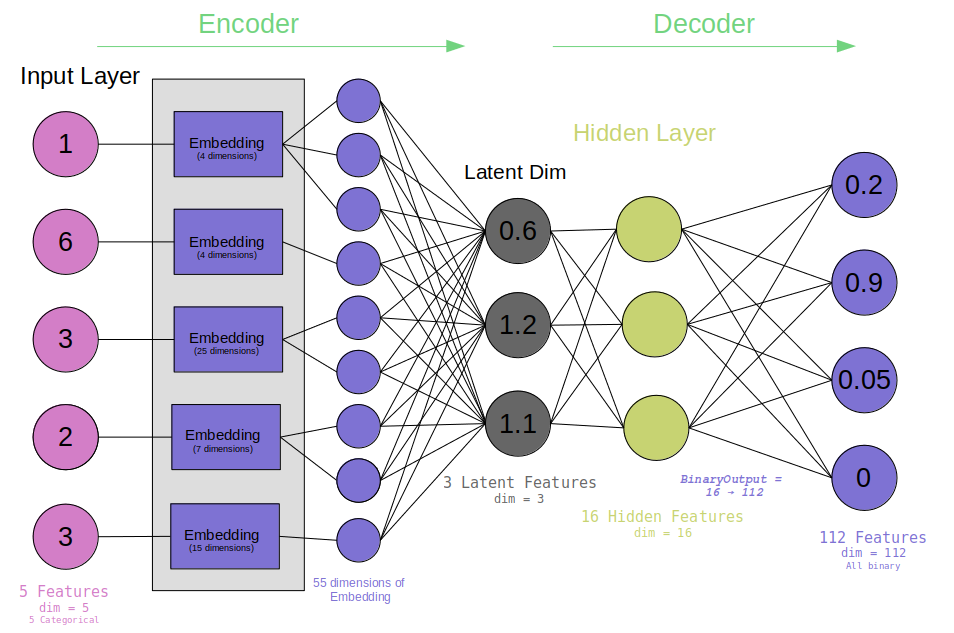

### First find a decent Learning Rate. 
> Create a trainer and run the find_lr function and plot. 

2020-11-12 15:21:46.241 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 309.89it/s]
2020-11-12 15:21:48.408 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


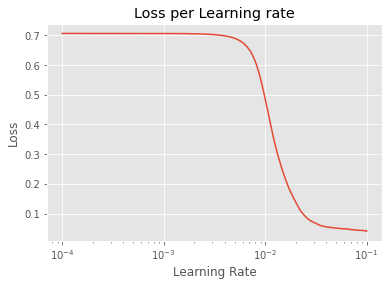

In [10]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

### Start Training and plot the results
> We train for __8 epochs__ and __learning rate 3e-3__. We see the model behaves fairly well during training. The loss goes up slightly in the middle of the training. This is the one_cycle logic which is reaching the max learning rate.

Epoch 005/005: 100%|██████████| 3817/3817 [00:10<00:00, 362.96it/s, train_loss=0.0122, val_loss=0.0082]


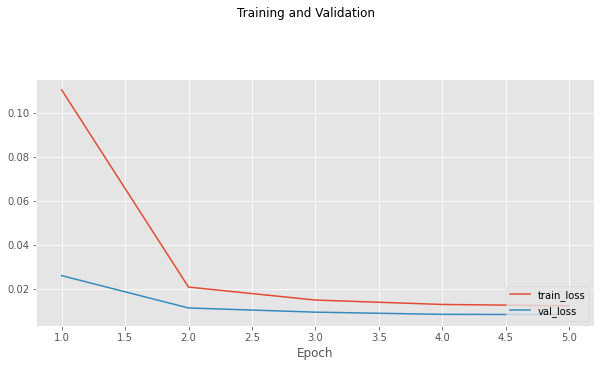

In [11]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(5, 3e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the Model

Creating Scores in 782 steps: 100%|██████████| 782/782 [00:01<00:00, 761.99it/s]


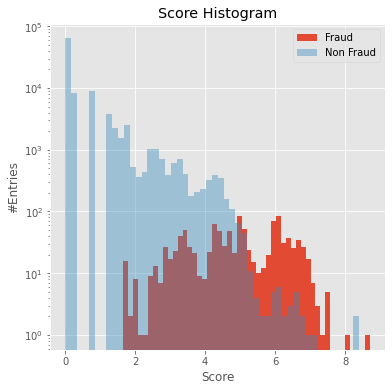

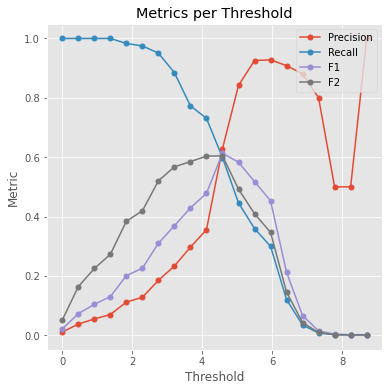

------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     98926
         1.0       0.58      0.61      0.60      1074

    accuracy                           0.99    100000
   macro avg       0.79      0.80      0.80    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9887
ap score  : 0.6504
-----------------------------------------------------


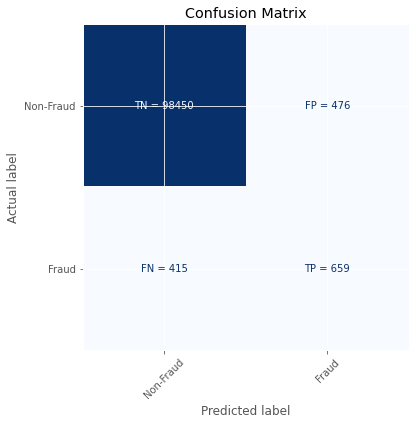

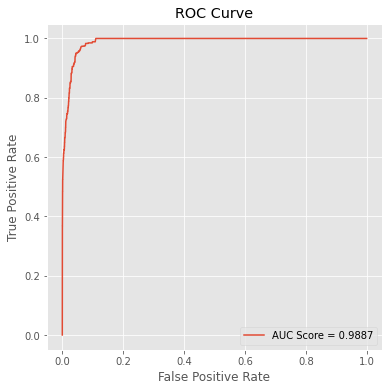

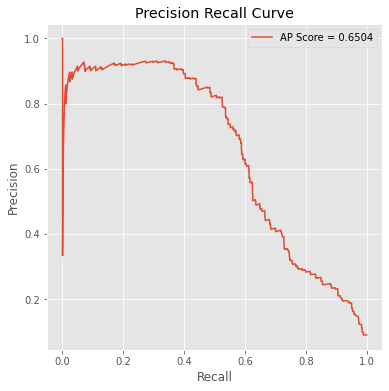

In [13]:
test_ds = pt.NumpyListDataSet(learning_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
tp = pl.TestPlot()
r = ts.score_plot()
tp.plot_scores(r, 50, fig_size=(6,6))
tp.plot_score_metrics(r, 20, fig_size=(6,6))
tp.print_classification_report(r, threshold=4.5)
tp.plot_confusion_matrix(r, fig_size=(6,6), threshold=4.5)
tp.plot_roc_curve(r, fig_size=(6,6))
tp.plot_precision_recall_curve(r, fig_size=(6,6))

## Plot Embeddings
> Because we now created an embedding (Like in one of the classifier examples) we can visualize it. The plot_embedding method will take the `FeatureIndex` named __category_i__, PCA it and display the 3 principal components. 

> It should be clear that this embedding is much different that the classifier example. The *es_leisure* us not longer a massive outlier and the first component no longer accounts for a incredible amount of variance. That should not be a surprise, the task we are trying to solve here is very different.

> In not evident accessing which 'aspects' are being visualised here. Taking a wild guess, the first component has transportation on one end and hotels on the other. That might potentially be related to the amount spent?

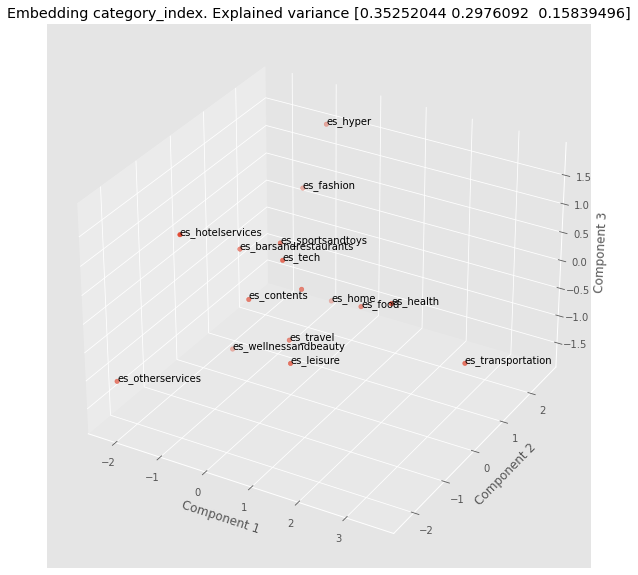

In [14]:
w = m.embedding_weights(category_i, True)
pl.LayerPlot().plot_embedding(category_i, w, dims=3, fig_size=(10,10))

# Conclusion
We showed that auto-encoders can use embeddings and that these embeddings caputure different 'aspects' of the data as compared to the embeddings created by the classifiers.

An interesting experiment would now be to see if we can take these embeddings and use them to classify fraud vs non-fraud. If that is the case, it would be interesting because having enough data is a typical problem in fraud detection, especially having enough __'fraud'__ data. Encoders do not need fraud data, they just capture aspects of the data. So if this works, one could train and auto-encoder on large amounts of data (which do not need to contain fraud data), take parts of that model to create a classifier and train that on much smaller data-sets that do need to contain fraud.

Above describe mechanism would be __transfer learning__, we will revist that in other notebooks.